In [2]:
from scipy.stats import chi2, norm, bernoulli, poisson
from scipy.stats import chisquare
import numpy as np
from matplotlib. pyplot import imshow, imread
import matplotlib.pyplot as plt

# 1


![Alt text](image-1.png)

# 8


![Alt text](image-2.png)

In [117]:
f_obs = np.array([9,20,14,8,11,10])  # observed (empirical) frequencies
n = f_obs.sum()  # sample size
N = len(f_obs)
p_0 = np.ones(N) / N  # uniform categorical distribution
f_exp = n * p_0  # expected frequencies
t, p_value = chisquare(f_obs, f_exp)  # chi-squared test
print(p_value, t)

0.147286351300178 8.166666666666666


In [118]:
# сам посчитаю статистику
statistics = np.sum((f_obs - f_exp)**2/f_exp)
p_value = 1 - chi2.cdf(statistics, N - 1)
print(f"stat: {statistics}; p_value: {p_value}")

stat: 8.166666666666666; p_value: 0.14728635130017798


p_value > alpha. Выборка не противоречит критерию

# 9

In [119]:
f_obs = np.array([74, 92, 83, 79, 80, 73, 77, 75, 76, 91])
n = f_obs.sum()
N = len(f_obs)
p_0 = np.ones(N)/N
exp_freq = p_0 * n

statistics = (((f_obs - exp_freq)**2) / exp_freq).sum()
p_value = 1 - chi2.cdf(statistics, N-1)

print(f"stat: {statistics}; p_value: {p_value}")

stat: 5.125; p_value: 0.8232783432788753


Выборка не противоречит гипотезе


# 10
В задаче нужно провести оценку параметра p. есть 4 события при испытаниях бернулли. (оо, ор, ро, рр). р - заболел, о - не заболел. Результаты (ор, ро) объединены в один. Распишем метод максимума правдоподобия и найдем параметр. Далее воспользуемся критерием Хи квадрат

![Alt text](image-3.png)

In [120]:
n = 200
f_obs = np.array([n - 181 - 9, 181, 9])
p = 199./400
exp_freq = n * np.array([(1-p)**2, 2 * p *(1-p), p**2])

chisquare(f_obs, exp_freq)

Power_divergenceResult(statistic=131.23466177606713, pvalue=3.182403754203728e-29)

pvalue $<< \alpha$. Гипотезу отвергаем.

# 11


![Alt text](image-4.png)

In [121]:
k = 2
N = 3
obs_1 = np.array([25, 50, 25])
obs_2 = np.array([52, 41, 7])
n1 = sum(obs_1)
n2 = sum(obs_2)
n = float(n1 + n2) # так как будем делить
apriori_p = (obs_1 + obs_2)/n
obs = [obs_1, obs_2]
n_s = [n1, n2]
statistics = 0.
for i in range(k):
    for j in range(N):
        statistics += (obs[i][j] - n_s[i]* apriori_p[j])**2 / (n_s[i] * apriori_p[j])
    
print(f"p_valie: {1 - chi2.cdf(statistics, (k-1)*(N-1))}")

p_valie: 3.5665697735942636e-05


отвергаем гипотезу о независимости от номера партии

# 12

проверяем гипотезы о равномерном распределении и о нормальном распределении. 

Сначала гипотеза о равномерном распределении.

In [122]:
# проверка гипотезы о равномерном распределении
obs = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
n = len(obs)
N = obs.sum()
apriori_p = np.ones((n), dtype=float)/n
apriori_freq = apriori_p * N

statistics = ((obs - apriori_freq)**2 / apriori_freq).sum()
print(f'stat = {statistics}')
print(f'pvalue: {1 - chi2.cdf(statistics, n - 1)}')

stat = 16.4
pvalue: 0.058984030544419586


наблюдения не противоречат гипотезе

далее рассмотрим нормальное распределение. Для него нужно будет воспользоваться методом максимума правдоподобия и найти параметры. 

Также оценим параметры в лоб. Это нам понадобится для построения квантизации.

In [78]:
# проведем грубую оценку параметров
numbers = np.array([i for i in range(10)])
mean = np.sum(numbers * obs)/ N
disp = np.sum(numbers**2 * obs)/N - mean**2
print(f"mean: {mean}; disp: {disp}")

mean: 4.77; disp: 6.277100000000004


Так как наблюдения дискретные, а распределение непрерывное, проведем квантизацию. А именно заведем корзины и поместим в них наблюдения. Мы посчитали среднее  = 4.77. По нему построим корзины: 

In [125]:
deltas = np.linspace(0.77, 8.77, 9)
deltas = np.concatenate([[-np.inf], deltas, [np.inf]])
deltas

array([-inf, 0.77, 1.77, 2.77, 3.77, 4.77, 5.77, 6.77, 7.77, 8.77,  inf])

и посчитаем сколько наблюдений попадает в каждую корзину. Эту величину обозначим $K_i$.

Далее пользуемся методом максимума правдоподобия

![Alt text](image-5.png)

Надеемся что полученные выражения являются сжатиями, и итерирование по ним сойдется.

In [126]:
import scipy.integrate as integrate
from scipy.stats import norm
deltas = np.linspace(0.77, 8.77, 9)
deltas = np.concatenate([[-np.inf], deltas, [np.inf]])
mean
disp

def integr(func, i):
    return integrate.quad(func,  deltas[i], deltas[i + 1])[0]
while True:
    new_mean = []
    new_disp = []
    f = lambda x: norm.pdf(x, loc = mean, scale = disp**0.5)
    xf = lambda x: x * norm.pdf(x, loc = mean, scale = disp**0.5)
    x_mu_f = lambda x: (x - mean) ** 2 * norm.pdf(x, loc = mean, scale = disp**0.5)
    
    for i in range(len(deltas) - 1):
        new_mean.append( obs[i] *  integr(xf, i)/ integr(f, i))
        new_disp.append(obs[i] *  integr(x_mu_f, i)/ integr(f, i))
    new_mean = sum(new_mean)/N
    new_disp = sum(new_disp)/N
    if np.allclose([mean, disp], [new_mean, new_disp], atol = 1e-10):
        disp = new_disp
        mean = new_mean
        break
    disp = new_disp
    mean = new_mean
print(f"likelihood mean: {mean}\n likelihood disp: {disp}")

likelihood mean: 5.059676805410929
 likelihood disp: 7.179825368644995


и применим критерий хи-квадрат с этими параметрами. 

In [127]:
f = lambda x: norm.pdf(x, loc = mean, scale = disp**0.5)
apriori_p = np.array([integr(f, i) for i in range(10)])
apriori_freq = N * apriori_p

statistics = sum((obs - apriori_freq)**2 / apriori_freq)
p_value = 1 - chi2.cdf(statistics, n -2)
print(f"statistics: {statistics}")
print(f"p_value: {p_value}")

statistics: 9.80255496484806
p_value: 0.2791584279175907


p_value второй гипотезы больше. Полученная выборка больше похожа на нормальное распределение чем на равномерное (вроде такие выводы)

# 36

Попытка решить в лоб

![Alt text](image-6.png)

Другое решение. Тут я в начальную гипотезу добавил условие $n1 + n2 = k$, где $n1, n2$ - количество наблюдений на 1 час и за 2 часа соответственно. Таким образом мы рассматриваем выполнение гипотезы только на подмножестве распределений. Если гипотеза верна, то критерий должен выполняться и на этом подмножестве, поэтому можно так делать

![Alt text](image-7.png)

In [128]:
from scipy.stats import norm, poisson, binom
n1 = 150
n2 = 250
p = 1./3
n_obs = n1

alpha = 0.05

def norm_crit(n_obs):
    n = n1 + n2
    mean = n * p
    delta = abs(mean - n_obs)
    quantile = -norm.ppf(alpha/2, loc = 0., scale = (n * p * (1 - p))**0.5)
    p_value = norm.cdf(-delta, loc = 0., scale = (n * p * (1 - p))**0.5) + \
                    1 - norm.cdf(delta, loc = 0., scale = (n * p * (1 - p))**0.5)
    return p_value, delta, quantile

def poisson_crit(n_obs):
    n = n1 + n2
    mean = n * p
    delta = abs(mean - n_obs)
    quantile_delta = mean - poisson.ppf(alpha/2, mu = n * p)
    p_value = poisson.cdf(mean - delta, mu = n * p) + \
                        1 -  poisson.cdf(mean + delta, mu = n * p)
    return p_value, delta, quantile_delta

def binom_crit(n_obs):
    n = n1 + n2
    mean = n * p
    delta = abs(mean - n_obs)
    quantile_delta = mean - binom.ppf(alpha/2, n = n, p = p)
    p_value = binom.cdf(mean - delta,  n = n, p = p) + \
                        1 -  binom.cdf(mean + delta,  n = n, p = p)
    return p_value, delta, quantile_delta

print("norm approximation:\np_value: {:.2f} ;delta from mean: {:.2f} ;acceptance interval :{:.2f}".format(*norm_crit(n1)))
print("poisson approximation:\np_value: {:.2f} ;delta from mean: {:.2f} ;acceptance interval :{:.2f}".format(*poisson_crit(n1)))
print("true binomial:\np_value: {:.2f} ;delta from mean: {:.2f} ;acceptance interval :{:.2f}".format(*binom_crit(n1)))

norm approximation:
p_value: 0.08 ;delta from mean: 16.67 ;acceptance interval :18.48
poisson approximation
p_value: 0.14 ;delta from mean: 16.67 ;acceptance interval :22.33
true binomial
p_value: 0.07 ;delta from mean: 16.67 ;acceptance interval :18.33


аппроксимация через пуассоновское распределение выдает бОльшее p_value, так как у пуассоновского распределения тяжелые хвосты.

Аппроксимация через нормальное распределение показывает результаты более похожие на результат без аппроксимации.

По обоим критериям наблюдения не противоречат гипотезе.

# 53

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-07.png)

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-08.png)

# 54

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-09.png)

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-10.png)

# 57

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-11.png)

# 58

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-12.png)
![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-13.png)

# 60

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-14.png)

required C: 0.033464083264969455


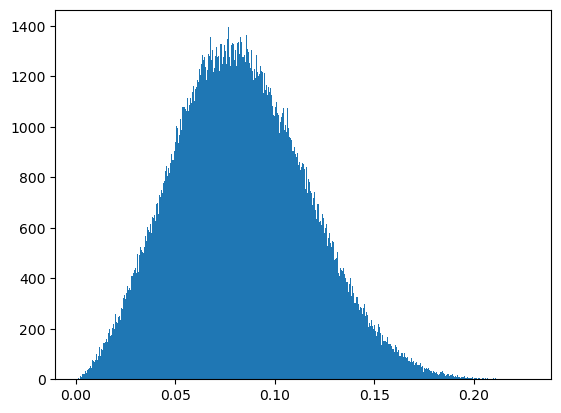

In [6]:
# оценка C с волной

n = 5
alpha = 0.06
iters = 500_000

stat = lambda x: np.mean(x**2)

stats = [stat(np.random.rand(n)- 0.5) for _ in range(iters)]

C = np.quantile(stats, alpha)
print(f"required C: {C}")
plt.hist(stats, bins = 1000)
plt.show()



# 70

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-15.png)

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-16.png)

оценим количество бросков в обоих случаях

получим зависимость $n(\Theta_0)$ для нескольких значений тета.

установим $\alpha = \beta = 0.04$

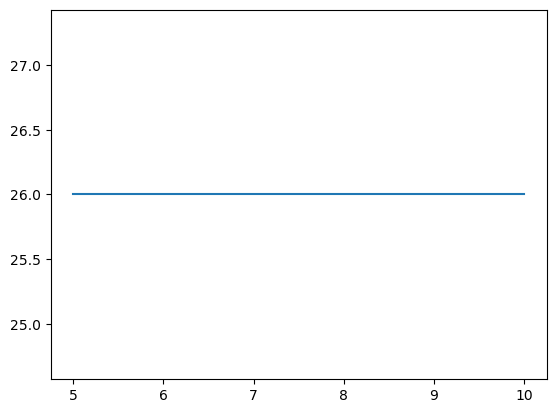

In [49]:
from scipy.stats import gamma, expon
theta_0 = np.linspace(5., 10, 10)
theta_1 = theta_0/2
alpha, beta = 0.04, 0.04

# scale = 1/beta
n_s = []
deltas = []
for i in range(len(theta_0)):
    n = 1
    while gamma.ppf(1 - beta, a = n, loc=0, scale=theta_1[i]) > gamma.ppf(alpha, a = n, loc=0, scale=theta_0[i]):
        n += 1
    n_s.append(n)
    deltas.append(gamma.ppf(1 - beta, a = n, loc=0, scale=theta_1[i]) - gamma.ppf(alpha, a = n, loc=0, scale=theta_0[i]))

plt.plot(theta_0, n_s)
plt.show()

получили что нужно 26 измерений для первого метода.

теперь рассмотрим второй метод

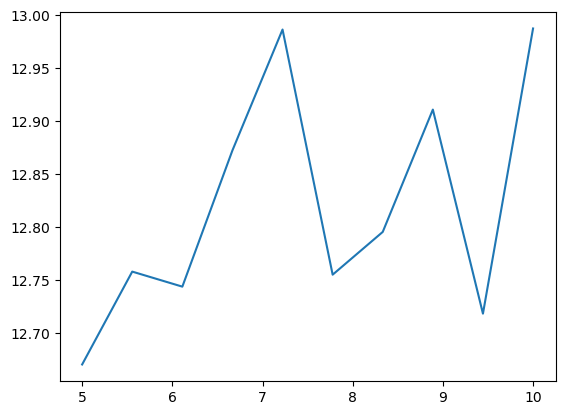

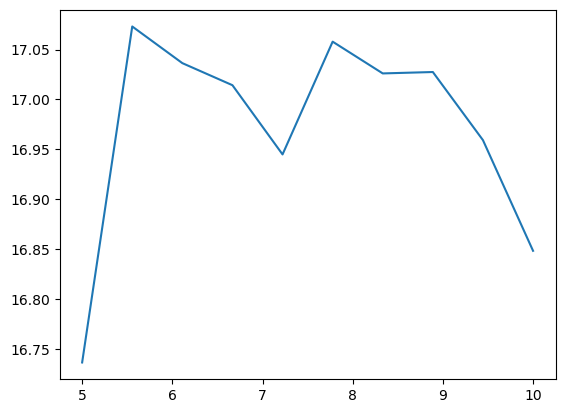

In [70]:
eps = 0.04

lower_bound, upper_bound = np.log(eps/(1-eps)), np.log((1-eps)/ eps)

iters = 10_000
n_s_0 = []
n_s_1 = []
for i in range(len(theta_0)):
    # generate from H0 and compute mean samples num
    n_s_i_0 = []
    n_s_i_1 = []
    for j in range(iters):
        stat = 0
        n = 0
        while( (stat > lower_bound) & (stat < upper_bound)):
            x_ = expon.rvs(size=1, scale = theta_0[i])
            stat += np.log(2) - 1./(2 * theta_1[i]) * x_
            n += 1
        n_s_i_0.append(n)

        stat = 0
        n = 0
        while (stat > lower_bound) & (stat < upper_bound):
            x_ = expon.rvs(size=1, scale = theta_1[i])
            stat += np.log(2) - 1./(2 * theta_1[i]) * x_
            n += 1
        n_s_i_1.append(n)
    n_s_0.append(np.mean(n_s_i_0))
    n_s_1.append(np.mean(n_s_i_1))
    
plt.plot(theta_0, n_s_0)
plt.show()
plt.plot(theta_0, n_s_1)
plt.show()

получили, что для второго метода нужно меньше семплов. Причем для принятия решения при верной первой гипотезе нужно еще меньше семплов

# 71
![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-17.png)

ошибка первого рода равна 0, но мощность тоже = 0.

Выводы: Рандомизированный критерий лучше

# 11

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-18.png)

![Alt text](./Дз%20статы%20Латыпов%201/Дз%20статы%20Латыпов%201-19.png)